# AdaGrad算法

问题：在训练过程中，某些特征出现的次数比较频繁，相关参数得到的更新次数较多，某些特征出现的次数不是很频繁，所以相关参数得到的更新次数就较少。在这两个情况中，我们选择较大的学习率会导致前者不稳定，选择较小的学习率会导致后者欠拟合。

上述问题会在语言模型或者是强化学习中出现，尽管强化学习中的相关经验池算法如PER、HER能够缓解这个问题，但是如何在训练上解决这个问题仍然是有意义的。

解决这个问题的一个方法是我们记录一下观测到的特定特征的次数，然后作为调整学习率的一个因子，譬如我们可以使用:
$$
\mathbf \eta_i = \frac {\eta_0}{\sqrt{s(i,t)+c}}
$$
的学习率，而不是$\eta = \frac{\eta_0}{\sqrt{t+c}}$，在这里我们的s(i,t)表示截止t时刻我们观测到的功能i的次数，这很容易实施，性能损耗也不大

## 具体实现
AdaGrad算法通过粗略的计数器$s(i,t)$替换为先前观察所得的梯度平方之后来解决这个问题。

它使用$s(i,t+1) = s(i,t) + (\partial_i f(x))^2$来调整学习率。

好处是：
- 不需要决定梯度合适算足够大
- 它会随着梯度的大小自动变化，通常对于较大梯度的坐标会显著地缩小，而其它梯度较小的坐标会得到更平滑的处理

## 数学形式
$$
\mathcal{g}_t = \partial_w \ l(y_t,f(x_t,\mathbf{w})),\\
\mathbf{s}_t = \mathbf{s}_{t-1} + \mathcal{g}_t^2,\\

\mathbf{w}_t = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}}  \cdot \mathbf{g}_t\\

$$

In [4]:
%matplotlib inline
import math 
import torch as t
import sys
sys.path.append("../")
from pltutils import *


epoch 20, x1: -2.382563, x2: -0.158591


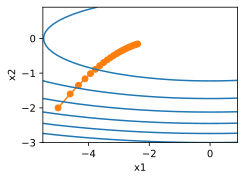

In [7]:
def adagrad_2d(x1,x2,s1,s2):
    eps = 1e-6
    g1,g2 = 0.2*x1,4*x2
    s1 += g1**2
    s2+= g2**2
    x1 -= eta/math.sqrt(s1+eps)*g1
    x2 -= eta/math.sqrt(s2+eps)*g2
    return x1,x2,s1,s2
def f_2d(x1,x2):
    return 0.1*x1**2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d,train_2d(adagrad_2d))


epoch 20, x1: -0.002295, x2: -0.000000


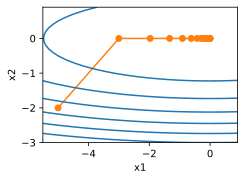

In [8]:
eta = 2
show_trace_2d(f_2d,train_2d(adagrad_2d))

epoch 20, x1: -0.000000, x2: -0.000000


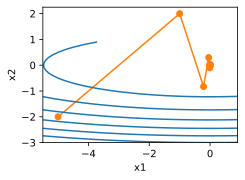

In [9]:
eta = 4
show_trace_2d(f_2d,train_2d(adagrad_2d))

#  AdaGrad 算法的实现

In [11]:
def init_adagrad_states(feature_dim):
    s_w  =t.zeros((feature_dim,1))
    s_b = t.zeros(1)
    return (s_w,s_b)

def adagrad(params,states,hyperparams):
    eps = 1e-6
    for p,s in zip(params,states):
        with t.no_grad():
            s[:] += t.square(p.grad)
            p[:] -= hyperparams["lr"] *p.grad / t.sqrt(s+eps)
        p.grad.data.zero_()
